In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../Donald Twitter Generation/input"))

['Donald-Tweets!.csv']


In [5]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import io

df = pd.read_csv('../Donald Twitter Generation/input/Donald-Tweets!.csv')
print(df.shape)
df.head()

(7375, 12)


,Date,Time,Tweet_Text,Type,Media_Type,Hashtags,Tweet_Id,Tweet_Url,twt_favourites_IS_THIS_LIKE_QUESTION_MARK,Retweets,Unnamed: 10,Unnamed: 11
0,16-11-11,15:26:37,Today we express our deepest gratitude to all ...,text,photo,ThankAVet,7.970000e+17,https://twitter.com/realDonaldTrump/status/797...,127213,41112,NaN,NaN
1,16-11-11,13:33:35,Busy day planned in New York. Will soon be mak...,text,NaN,NaN,7.970000e+17,https://twitter.com/realDonaldTrump/status/797...,141527,28654,NaN,NaN
2,16-11-11,11:14:20,Love the fact that the small groups of protest...,text,NaN,NaN,7.970000e+17,https://twitter.com/realDonaldTrump/status/797...,183729,50039,NaN,NaN
3,16-11-11,2:19:44,Just had a very open and successful presidenti...,text,NaN,NaN,7.970000e+17,https://twitter.com/realDonaldTrump/status/796...,214001,67010,NaN,NaN
4,16-11-11,2:10:46,A fantastic day in D.C. Met with President Oba...,text,NaN,NaN,7.970000e+17,https://twitter.com/realDonaldTrump/status/796...,178499,36688,NaN,NaN


## inspect text

In [6]:
# lowercase all
text = df['Tweet_Text'].str.lower()

we probably want to keep the hashtags, but if there are for example random characters (like links), we want to drop them so they won't affct the precictions

In [8]:
np.random.seed(12345)
np.random.choice(text,10)

array(['i will be on @meetthepress in an interview with @chucktodd on sunday morning. so much to talk about!',
       '"minorities line up behind donald trump" #trump2016\nhttps://t.co/clcvogwomy',
       'make america great again!\n#inprimary #votetrump\nhttps://t.co/nmqekxccv6',
       'thank you for all of your support iowa!\n#makeamericagreatagain #trump2016\n#iacaucus finder: https://t.co/anvtczqfoq https://t.co/fqaxume01b',
       '"every american needs to say 2 simple words to every vet they meet: thank you!" john wayne walding\nhttps://t.co/wg8ezphzt1',
       'a suicide bomber has just killed u.s. troops in afghanistan. when will our leaders get tough and smart. we are being led to slaughter!',
       'thank you, new hampshire! great people -- see you next week! https://t.co/r83xq8kxp5',
       'during primetime of the iowa caucus, cruz put out a release that @realbencarson was quitting the race, and to caucus (or vote) for cruz.',
       'thank you tennessee! #maga https://t.

In [9]:
print('BEFORE:')
print(text[0])
text = text.map(lambda s: ' '.join([x for x in s.split() if 'http' not in x]))
print('AFTER:')
print(text[0])

BEFORE:
today we express our deepest gratitude to all those who have served in our armed forces. #thankavet https://t.co/wpk7qwpk8z
AFTER:
today we express our deepest gratitude to all those who have served in our armed forces. #thankavet


any super short tweets?

max tweet len: 151
min tweet len: 0


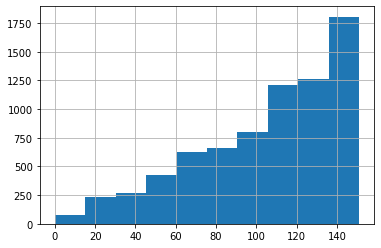

In [11]:
print('max tweet len:',text.map(len).max())
print('min tweet len:',text.map(len).min())
text.map(len).hist()

In [12]:
text = text[text.map(len)>60]
len(text)

6366

## Get Chars Dictionary

In [13]:
chars = sorted(list(set(''.join(text))))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: 78


Inspect Chars

In [14]:
chars

[' ',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '=',
 '?',
 '@',
 '[',
 ']',
 '_',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '{',
 '|',
 '}',
 '~',
 'ʉ',
 '̱',
 'ω',
 'я',
 'ӕ',
 'ԍ',
 'ԏ',
 'ԡ',
 'լ',
 'ջ',
 'ُ',
 '٪',
 '\u06dd',
 'ۢ',
 '۪']

maybe last ones are emojis?
Let's take a look at sentences with the weird chars.

In [15]:
for c in chars[-19:]:
    print('\nCHAR:', c)
    smple = [x for x in text if c in x]
    print(random.sample(smple,min(3,len(smple))))


CHAR: {
['"{crooked hillary clinton} created this mess, and she knows it." #draintheswamp']

CHAR: |
['join me in florida on wednesday! daytona &amp; jacksonville: daytona | 3pm- jacksonville | 7pm-', '"@politico: palin on 2016: "i think it would come down to cruz and trump! | getty', 'rt @danscavino: 2016 gop primary hp tracking 139 polls | 28 pollsters. #1 trump 24.1% #2 bush 10.7% #3 carson 8.6% #4 rubio 6.8%']

CHAR: }
['"{crooked hillary clinton} created this mess, and she knows it." #draintheswamp']

CHAR: ~
['"@destiny: why didnt @seanhannity correct jeb when he said @realdonaldtrump has run 4 president 2x b4~jeb needs 2b corrected b/c he lied."', 'join me in roanoke, virginia tomorrow at the berglund center- coliseum ~ 6pm! tickets available at:_', '"@freestateyank: "the only way anybodys gonna beat trump is being better than he is."~@rushlimbaugh on @realdonaldtrump."']

CHAR: ʉ
['my pro-growth econ plan: eliminate excessive regulations! lean government! lower taxes! #debates

still weird....
let's remove them

In [16]:
import re
for c in chars[-19:]:
    text = text.str.replace(c,'')

In [17]:
chars = sorted(list(set(''.join(text))))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

chars

total chars: 59


[' ',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '=',
 '?',
 '@',
 '[',
 ']',
 '_',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

## Create Input Data
<br>
input - 40 characters of a tweet
<br>
output - next character

In [18]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 1
sentences = []
next_chars = []
for x in text:
    for i in range(0, len(x) - maxlen, step):
        sentences.append(x[i: i + maxlen])
        next_chars.append(x[i + maxlen])
print('nb sequences:', len(sentences))

nb sequences: 472774


In [19]:
## check example
for i in range(3):
    print(sentences[i],'==>',next_chars[i])

today we express our deepest gratitude t ==> o
oday we express our deepest gratitude to ==>  
day we express our deepest gratitude to  ==> a


In [20]:
text[0]

'today we express our deepest gratitude to all those who have served in our armed forces. #thankavet'

## Vectorization
1. Turn X into matrix of (numer_of_sentences,max_len_of_sentence,num_chars).
<br>
If char i is number j char in sentence k, there will be a 1 in location (k,j,i)
<br>
2. Turn y into a vector of (number_of_sentences,num_chars).
<br>
If character z is the next character in sentence k, there will be a 1 in locaiton (k,z)

In [23]:
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Vectorization...


## build the model: a single LSTM

1. Define we have a sequential model
2. Add an LSTM layer with 128 units. Input shape is a matrix of maxlen characters, where each character is a vector of len(chars)
3. Add a dense layer (fully connected layer) and have the softmax activation pick a winner from the len(chars) possible characters.
4. Pick an optimizer for the network and choose categorical_crossentropy loss function (used in multiclass classification).

In [26]:
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

# optimizer = RMSprop(lr=0.01)
optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Build model...







## Sampler
We don't want the next character to be the one with the highest probaility (we'll get the same results every time).
So we sample with temperature parameter

In [27]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

example of what the function does:

In [35]:
for temperature in [0.1, 0.2, 0.3,  0.5, 1.0, 1.2, 1.3]:
    print(sample([.1,.3,.5,.1],temperature=temperature))

2
1
2
1
2
3
2


We gave the function an array where highest probability was index number 2 (.5).
When temperature was low, we got what we expected.
As we increased the temperature, the function got more creative license choosing the max.
So:
1. temperature helps us not get the same text generated every time
2. low temperature = text similar to trained data
3. high temperature = more creative generation
4. too high temperature = nonsense.

## Generate Text at Epoch End

In [37]:
def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)
    
#     start_index = random.randint(0, len(text) - maxlen - 1)
    tweet = np.random.choice(text) # select random tweet
    start_index = 0

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = tweet[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(120):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

In [38]:
epochs = 5

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

model.fit(x, y,
          batch_size=128,
          epochs=epochs,
          callbacks=[print_callback])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/5
472774/472774 [==============================] - 398s 841us/step - loss: 2.3545

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "the press has very inaccurately covered "
the press has very inaccurately covered the whe hes and the reald the wall the reald not the reald the reald and the the reald the wall the reald the realdont t
----- diversity: 0.5
----- Generating with seed: "the press has very inaccurately covered "
the press has very inaccurately covered deally the heper the not the cand be the realdont trump the reate a dong to make mericangreat again @trunghentathat and 
----- diversity: 1.0
----- Generating with seed: "the press has very inaccurately covered "
the press has very inaccurately covered nillly. thevecice #meic@ter.hinu2_" fain elly out us ybe nogs yout 21%.!! #saby2_e1620y%" 2" no sur sub arestatis. ngrey
----- diversity: 1

KeyboardInterrupt: 

In [39]:
print('Build model...')
model2 = Sequential()
model2.add(LSTM(128, input_shape=(maxlen, len(chars)),return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(128))
model2.add(Dropout(0.2))
model2.add(Dense(len(chars), activation='softmax'))

# optimizer = RMSprop(lr=0.01)
optimizer = Adam()
model2.compile(loss='categorical_crossentropy', optimizer=optimizer)

Build model...
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
epochs = 60

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

model2.fit(x, y,
          batch_size=128,
          epochs=epochs,
          callbacks=[print_callback])

Epoch 1/60
375424/472774 [======================>.......] - ETA: 10:10 - loss: 2.4233